<a href="https://colab.research.google.com/github/thatlq1812/DPL302m_Project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

wait for fill

> Step 0. Introduction - Importing libraries and loading data

> Step 1. Data analysis and preprocessing

> Step 2. Model selection

> Step 3. Model training

> Step 4. Model evaluation

> Step 5. Model prediction

> Step 6. Model submission

> Step 7. Conclusion

First, import the necessary libraries section.

In [1]:
# Goolge Colab library
try:
    from google.colab import drive
    import torch_xla.core.xla_model as xm
except:
    pass

In [2]:
# Python library
import os
import zipfile
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import pickle as pkl
import yaml
import albumentations as A

from glob import glob
from tqdm import tqdm
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed

# Sklearn library
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Pytorch library
import torch
from torch import optim, nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# CV2 library
import cv2

# Goolge Colab library
try:
    import torch_xla.core.xla_model as xm
    from google.colab import drive

except:
    pass

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
try:
    drive.mount('/content/drive')
    if not os.path.exists("/content/data"):
        !cp "/content/drive/My Drive/Colab Notebooks/data.zip" "/content/"
        with zipfile.ZipFile("data.zip", 'r') as zip_ref:
            zip_ref.extractall("/content/")
except:
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load configuration
with open('config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Project information
print('Project name: ', config['project']['name'])
print('Project version: ', config['project']['description'])
print('Project author: ', config['project']['author'])
print('Project version: ', config['project']['version'])

# Data location
print('Data path: ', config['data'])
data_path = config['data']['data_path']
csv_path = config['data']['csv_path']
images_path = config['data']['images_path']

# Training configuration
n_workers = multiprocessing.cpu_count()
batch_size = config['training']['batch_size']
print('N workers: ', n_workers)
print('Batch size: ', batch_size)

# Preprocessing configuration
print('Preprocessing configuration')
augmentation_ratio = config['preprocessing']['augmentation']['ratio']
resize_shape = tuple(config['preprocessing']['resize'])
print('Augmentation ratios: ', augmentation_ratio)
print('Resize shape: ', resize_shape)

# Create a dictionary for images location
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Project name:  Cancer Detection
Project version:  DPL302m Project - Fall 2024 of Group 1
Project author:  Group 1
Project version:  1.0.0
Data path:  {'data_path': 'data/', 'csv_path': 'data/HAM10000_metadata.csv', 'images_path': 'data/images/'}
N workers:  2
Batch size:  32
Preprocessing configuration
Augmentation ratios:  1
Resize shape:  (64, 64)


In [5]:
# Data reading
data = pd.read_csv(csv_path)

In [6]:
def data_check(data):
    # Show data types
    print('Data types:')
    print(data.dtypes)
    print()

    # Show unique values for each column (skip image_id and lesion_id)
    print('Unique values for each column:')
    for col in data.columns:
        if col in ['image_id', 'lesion_id']:
            continue
        print(f"{col}: {data[col].unique()[:5]}...")
    print()

    # Count NaN values
    print('NaN values in each column:')
    nan_counts = data.isnull().sum()
    print(nan_counts[nan_counts > 0])
    print()

    # Count 'unknown' values (only for object columns)
    print('Unknown values in each column:')
    for col in data.select_dtypes(include=['object']).columns:
        unknown_count = data[data[col] == 'unknown'].shape[0]
        if unknown_count > 0:
            print(f"{col}: {unknown_count}")
    print()

    # Summary
    print("Summary of potential data issues:")
    print(f"- Columns with NaN values: {nan_counts[nan_counts > 0].index.tolist()}")
    print(f"- Columns with 'unknown' values: {[col for col in data.columns if 'unknown' in data[col].values]}")



In [7]:
data_check(data)

Data types:
lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

Unique values for each column:
dx: ['bkl' 'nv' 'df' 'mel' 'vasc']...
dx_type: ['histo' 'consensus' 'confocal' 'follow_up']...
age: [80. 75. 60. 70. 55.]...
sex: ['male' 'female' 'unknown']...
localization: ['scalp' 'ear' 'face' 'back' 'trunk']...

NaN values in each column:
age    57
dtype: int64

Unknown values in each column:
sex: 57
localization: 234

Summary of potential data issues:
- Columns with NaN values: ['age']
- Columns with 'unknown' values: ['sex', 'localization']


In [8]:
def data_cleaning(data):
    # Drop duplicates defined by 'image_id' and 'lesion_id'
    data = data.drop_duplicates(subset=['image_id'])

    # Drop values with NaN
    data = data.dropna(subset=['age', 'sex', 'localization'])
    data = data[data['age'] != 'unknown']
    data = data[data['sex'] != 'unknown']
    data = data[data['localization'] != 'unknown']

    # Convert 'age' to int
    try:
        data['age'] = data['age'].astype(int)
    except ValueError:
        print("Some 'age' values could not be converted to int.")

    # Create label encoders for each categorical column
    label_encoder_dx = LabelEncoder()
    label_encoder_dx_type = LabelEncoder()
    label_encoder_sex = LabelEncoder()
    label_encoder_localization = LabelEncoder()

    # Encode labels
    data['dx_code'] = label_encoder_dx.fit_transform(data['dx'])
    data['dx_type_code'] = label_encoder_dx_type.fit_transform(data['dx_type'])
    data['sex_code'] = label_encoder_sex.fit_transform(data['sex'])
    data['localization_code'] = label_encoder_localization.fit_transform(data['localization'])

    # Add location of images
    data['image_id'] = data['image_id'].apply(lambda x: os.path.join(images_path, x + '.jpg'))

    print('Data after cleaning:')
    print(data.head())

    data = data.reset_index(drop=True)

    return data

In [9]:
data = data_cleaning(data)
data_check(data)

Data after cleaning:
     lesion_id                      image_id   dx dx_type  age   sex  \
0  HAM_0000118  data/images/ISIC_0027419.jpg  bkl   histo   80  male   
1  HAM_0000118  data/images/ISIC_0025030.jpg  bkl   histo   80  male   
2  HAM_0002730  data/images/ISIC_0026769.jpg  bkl   histo   80  male   
3  HAM_0002730  data/images/ISIC_0025661.jpg  bkl   histo   80  male   
4  HAM_0001466  data/images/ISIC_0031633.jpg  bkl   histo   75  male   

  localization  dx_code  dx_type_code  sex_code  localization_code  
0        scalp        2             3         1                 11  
1        scalp        2             3         1                 11  
2        scalp        2             3         1                 11  
3        scalp        2             3         1                 11  
4          ear        2             3         1                  4  
Data types:
lesion_id            object
image_id             object
dx                   object
dx_type              object
age     

In [10]:
def split_data(data, test_size=0.2, random_state=42):
    # Split data into training and testing sets
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=random_state)
    print("Train data shape:", train_data.shape)
    print("Test data shape:", test_data.shape)

    return train_data, test_data

In [11]:
train_data, test_data = split_data(data, config['training']['test_size'], config['training']['random_state'])

Train data shape: (7808, 11)
Test data shape: (1953, 11)


In [12]:
def load_images_worker(batch):
    images = []
    for index, row in batch.iterrows():
        image_path = row['image_id']
        image = cv2.imread(image_path)
        if image is None:
            print('Image not found: ', image_path)
            continue
        # Preprocess image
        image = cv2.resize(image, resize_shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    return images

def load_images(data, batch_size, num_workers):
    all_images = []
    batches = [data[i:i + batch_size] for i in range(0, len(data), batch_size)]
    st = time.time()
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(load_images_worker, batch): batch for batch in batches}

        for future in tqdm(as_completed(futures), total=len(futures)):
            img_batch = future.result()
            if img_batch is not None:
                all_images.extend(img_batch)
    et = time.time()
    print('Loaded {} images in {} seconds'.format(len(all_images), et - st))
    return all_images

In [13]:
# Load train images
images = load_images(data, batch_size=batch_size, num_workers=n_workers)
train_images = load_images(train_data, batch_size=batch_size, num_workers=n_workers)
test_images = load_images(test_data, batch_size=batch_size, num_workers=n_workers)

100%|██████████| 306/306 [01:16<00:00,  4.02it/s]


Loaded 9761 images in 76.171865940094 seconds


100%|██████████| 244/244 [00:37<00:00,  6.54it/s]


Loaded 7808 images in 37.31960368156433 seconds


100%|██████████| 62/62 [00:11<00:00,  5.27it/s]

Loaded 1953 images in 11.772032976150513 seconds


In [14]:
def type_count(data, rate):
    lesion_type = data.groupby(data['dx']).count()
    lesion_type = lesion_type.reset_index()
    lesion_type = lesion_type[['dx', 'image_id']]
    lesion_type.columns = ['dx', 'count']
    lesion_type = lesion_type.sort_values(by='count', ascending=False)
    print(lesion_type)
    max_count = lesion_type['count'].max()
    augmentation_counts = {}
    for index, row in lesion_type.iterrows():
        augmentation_counts[row['dx']] = int(max_count / row['count'] * rate)
    return augmentation_counts

In [15]:
augmentation_counts = type_count(train_data, config['preprocessing']['augmentation']['ratio'])
print("Augmentation Ratios:", augmentation_counts)
_ = type_count(test_data, 0)

      dx  count
5     nv   5205
4    mel    876
2    bkl    849
1    bcc    404
0  akiec    265
6   vasc    120
3     df     89
Augmentation Ratios: {'nv': 1, 'mel': 5, 'bkl': 6, 'bcc': 12, 'akiec': 19, 'vasc': 43, 'df': 58}
      dx  count
5     nv   1286
2    bkl    227
4    mel    225
1    bcc    105
0  akiec     62
3     df     26
6   vasc     22


In [16]:
run_augmentation = True

def augment_image_worker(row, image, augmentations, augmentation_counts):
    augmented_images = []
    augmented_data = []

    lesion_type = row['dx']
    count = augmentation_counts.get(lesion_type, 0)
    if count == 0:
        return None, None

    for _ in range(count):
        if _ == 0:
            augmented_images.append(image)
            augmented_row = row.copy()
            augmented_row['image_id'] = row['image_id'] + '_original'
            augmented_data.append(augmented_row)
            continue

        augment_image = augmentations(image=image)
        augmented_images.append(augment_image['image'])
        augmented_row = row.copy()
        augmented_row['image_id'] = row['image_id'] + '_augmented_' + str(_)
        augmented_data.append(augmented_row)

    return augmented_data, augmented_images

def augment_images(data, images_array, augmentation_counts, num_workers=n_workers):
    augmentations = A.Compose([
        A.HorizontalFlip(p=0.25),
        A.VerticalFlip(p=0.25),
        A.Rotate(limit=(0, 180), p=0.25),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    ])

    print(f'Number of images: {len(images_array)}, Number of rows in data: {len(data)}')

    augmented_images = []
    augmented_data = []

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = []

        for index, row in tqdm(data.iterrows(), total=len(data), desc="Augmenting Images"):
            futures.append(
                executor.submit(augment_image_worker, row, images_array[index], augmentations, augmentation_counts)
            )

        for future in tqdm(as_completed(futures), total=len(futures), desc="Collecting Results"):
            aug_data, aug_images = future.result()
            if aug_data is not None and aug_images is not None:
                augmented_data.extend(aug_data)
                augmented_images.extend(aug_images)

    augmented_data = pd.DataFrame(augmented_data)

    return augmented_data, augmented_images


In [17]:
if run_augmentation:
    augmented_train_data, augmented_train_images = augment_images(train_data, images, augmentation_counts)
else:
    augmented_train_data, augmented_train_images = train_data.copy(), images.copy()

print('Train data shape: ', train_data.shape)
print('Augmented data shape: ', augmented_train_data.shape)
print('Augmented images length: ', len(augmented_train_images))

Number of images: 9761, Number of rows in data: 7808


Augmenting Images: 100%|██████████| 7808/7808 [00:00<00:00, 7900.40it/s]


Train data shape:  (7808, 11)
Augmented data shape:  (34884, 11)
Augmented images length:  34884


In [18]:
_ = type_count(augmented_train_data, 0)

      dx  count
5     nv   5205
3     df   5162
6   vasc   5160
2    bkl   5094
0  akiec   5035
1    bcc   4848
4    mel   4380


In [19]:
def compute_img_mean_std_worker(batch_images):
    img_w, img_h = resize_shape
    batch_imgs = []

    for image in batch_images:
        img = cv2.resize(image, (img_w, img_h))
        batch_imgs.append(img)

    return np.array(batch_imgs)

def compute_img_mean_std(augmented_images, batch_size=32, num_workers=n_workers):
    means = np.zeros(3)
    stdevs = np.zeros(3)
    total_count = 0

    # Split images into batches
    batches = [augmented_images[i:i + batch_size] for i in range(0, len(augmented_images), batch_size)]

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(compute_img_mean_std_worker, batch): batch for batch in batches}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Batches"):
            img_batch = future.result()
            if img_batch is not None:
                img_batch = img_batch.astype(np.float32) / 255.0  # Normalize

                # Compute mean and std for each channel in the batch
                for i in range(3):  # RGB channels
                    means[i] += img_batch[:, :, :, i].mean() * img_batch.shape[0]
                    stdevs[i] += (img_batch[:, :, :, i] ** 2).mean() * img_batch.shape[0]

                total_count += img_batch.shape[0]  # Update total count

    # Compute means and stds
    means /= total_count
    stdevs = np.sqrt(stdevs / total_count - means ** 2)

    return means, stdevs

In [20]:
# Return the mean and std of the images
print('Number of images: ', len(augmented_train_images))
norm_mean, norm_std = compute_img_mean_std(augmented_train_images, batch_size=batch_size, num_workers=n_workers)
print('Normed means: ', norm_mean)
print('Normed stds: ', norm_std)

Number of images:  34884


Processing Batches: 100%|██████████| 1091/1091 [00:01<00:00, 704.59it/s]


Normed means:  [0.75112905 0.5718805  0.60222207]
Normed stds:  [0.15315418 0.16563931 0.17785515]


In [21]:
train_data_droped = augmented_train_data.drop(columns=['lesion_id', 'image_id', 'dx', 'dx_type','sex','localization'])
train_data.head()
train_data_droped.head()
train_data_droped = train_data_droped.astype('float32')
train_data_droped.reset_index(drop=True, inplace=True)

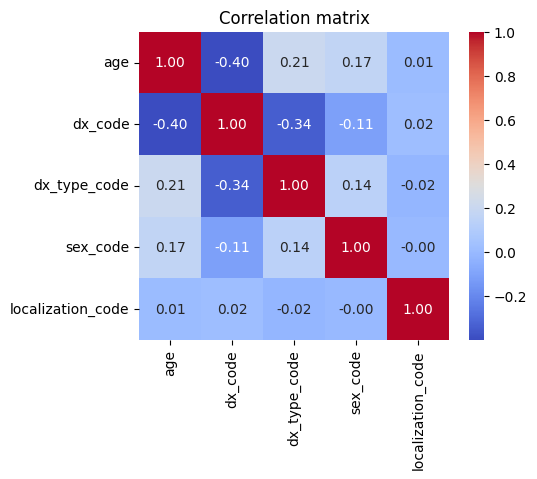

In [22]:
corr = train_data_droped.corr()
plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix')
plt.show()

In [23]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting.
# If feature_extract = False, the model is finetuned and all model parameters are updated.
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [24]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    # Variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = resize_shape[0]


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = resize_shape[0]


    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = resize_shape[0]


    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

In [25]:
# resnet,vgg,densenet,inception
model_name = 'densenet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
try:
    device = xm.xla_device()
except:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Put the model on the device:
model = model_ft.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [26]:
# define the transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])

In [27]:
# 	age	dx_code	dx_type_code	sex_code	localization_code

class HAM10000(Dataset):
    def __init__(self, df, images_array, transform=None):
        self.df = df.reset_index(drop=True)
        self.images_array = images_array  # Mảng chứa các ảnh
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Lấy ảnh từ mảng và nhãn từ DataFrame
        X = self.images_array[index]
        y = torch.tensor(int(self.df['dx_code'][index]))

        if self.transform:
            X = self.transform(X)

        # Có thể trả về thêm thông tin khác nếu cần
        additional_info = {
            'age': torch.tensor(int(self.df['age'][index])),
            'dx_type': torch.tensor(int(self.df['dx_type_code'][index])),
            'sex_code': torch.tensor(int(self.df['sex_code'][index])),
            'localization': torch.tensor(int(self.df['localization_code'][index]))
        }

        return X, y, additional_info


In [28]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(train_data_droped,augmented_train_images,transform=transform)
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=n_workers)
# Same for the validation set:
validation_set = HAM10000(test_data,test_images, transform=transform)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=n_workers)

In [29]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

Train step

In [30]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [31]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        images, labels, _ = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [32]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_loader), total=len(val_loader)):
            images, labels, additional_info = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [33]:
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    print('Training on epoch {}'.format(epoch))
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('Best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

Training on epoch 1


  9%|▉         | 101/1091 [00:13<01:19, 12.38it/s]

[epoch 1], [iter 100 / 1091], [train loss 1.32117], [train acc 0.51562]


 18%|█▊        | 201/1091 [00:21<01:04, 13.72it/s]

[epoch 1], [iter 200 / 1091], [train loss 1.20948], [train acc 0.56547]


 28%|██▊       | 302/1091 [00:30<00:58, 13.57it/s]

[epoch 1], [iter 300 / 1091], [train loss 1.12144], [train acc 0.59719]


 37%|███▋      | 401/1091 [00:38<01:14,  9.26it/s]

[epoch 1], [iter 400 / 1091], [train loss 1.06071], [train acc 0.61805]


 46%|████▌     | 502/1091 [00:46<00:44, 13.23it/s]

[epoch 1], [iter 500 / 1091], [train loss 1.02347], [train acc 0.63156]


 55%|█████▍    | 600/1091 [00:58<02:18,  3.55it/s]

[epoch 1], [iter 600 / 1091], [train loss 0.98290], [train acc 0.64417]


 64%|██████▍   | 702/1091 [01:07<00:28, 13.47it/s]

[epoch 1], [iter 700 / 1091], [train loss 0.95030], [train acc 0.65594]


 74%|███████▎  | 802/1091 [01:16<00:21, 13.61it/s]

[epoch 1], [iter 800 / 1091], [train loss 0.92367], [train acc 0.66523]


 83%|████████▎ | 902/1091 [01:23<00:13, 13.71it/s]

[epoch 1], [iter 900 / 1091], [train loss 0.89662], [train acc 0.67500]


 92%|█████████▏| 1001/1091 [01:32<00:06, 13.54it/s]

[epoch 1], [iter 1000 / 1091], [train loss 0.87137], [train acc 0.68400]


100%|██████████| 62/62 [00:03<00:00, 20.42it/s]

------------------------------------------------------------
[epoch 1], [val loss 0.70147], [val acc 0.71976]
------------------------------------------------------------
*****************************************************
Best record: [epoch 1], [val loss 0.70147], [val acc 0.71976]
*****************************************************
Training on epoch 2



  9%|▉         | 102/1091 [00:08<01:14, 13.25it/s]

[epoch 2], [iter 100 / 1091], [train loss 0.57052], [train acc 0.78312]


 19%|█▊        | 202/1091 [00:17<01:07, 13.11it/s]

[epoch 2], [iter 200 / 1091], [train loss 0.57647], [train acc 0.78438]


 28%|██▊       | 302/1091 [00:25<01:01, 12.91it/s]

[epoch 2], [iter 300 / 1091], [train loss 0.58036], [train acc 0.78312]


 37%|███▋      | 401/1091 [00:34<00:52, 13.20it/s]

[epoch 2], [iter 400 / 1091], [train loss 0.57548], [train acc 0.78680]


 46%|████▌     | 501/1091 [00:42<00:54, 10.91it/s]

[epoch 2], [iter 500 / 1091], [train loss 0.58967], [train acc 0.78187]


 55%|█████▌    | 602/1091 [00:51<00:37, 13.10it/s]

[epoch 2], [iter 600 / 1091], [train loss 0.58879], [train acc 0.78187]


 64%|██████▍   | 701/1091 [01:00<01:11,  5.44it/s]

[epoch 2], [iter 700 / 1091], [train loss 0.59163], [train acc 0.78103]


 74%|███████▎  | 802/1091 [01:08<00:21, 13.25it/s]

[epoch 2], [iter 800 / 1091], [train loss 0.61252], [train acc 0.77551]


 83%|████████▎ | 901/1091 [01:19<00:14, 12.67it/s]

[epoch 2], [iter 900 / 1091], [train loss 0.61610], [train acc 0.77420]


 92%|█████████▏| 1001/1091 [01:27<00:06, 13.09it/s]

[epoch 2], [iter 1000 / 1091], [train loss 0.60848], [train acc 0.77691]


100%|██████████| 62/62 [00:02<00:00, 28.62it/s]

------------------------------------------------------------
[epoch 2], [val loss 0.69793], [val acc 0.73488]
------------------------------------------------------------
*****************************************************
Best record: [epoch 2], [val loss 0.69793], [val acc 0.73488]
*****************************************************
Training on epoch 3



  9%|▉         | 101/1091 [00:09<01:57,  8.46it/s]

[epoch 3], [iter 100 / 1091], [train loss 0.43712], [train acc 0.83562]


 18%|█▊        | 201/1091 [00:17<01:08, 12.92it/s]

[epoch 3], [iter 200 / 1091], [train loss 0.44867], [train acc 0.82984]


 28%|██▊       | 302/1091 [00:26<00:59, 13.27it/s]

[epoch 3], [iter 300 / 1091], [train loss 0.45864], [train acc 0.82844]


 37%|███▋      | 402/1091 [00:34<00:51, 13.34it/s]

[epoch 3], [iter 400 / 1091], [train loss 0.46118], [train acc 0.83031]


 46%|████▌     | 502/1091 [00:43<00:44, 13.28it/s]

[epoch 3], [iter 500 / 1091], [train loss 0.45676], [train acc 0.83206]


 55%|█████▌    | 602/1091 [00:51<00:47, 10.36it/s]

[epoch 3], [iter 600 / 1091], [train loss 0.45045], [train acc 0.83339]


 64%|██████▍   | 701/1091 [01:00<00:30, 12.62it/s]

[epoch 3], [iter 700 / 1091], [train loss 0.44606], [train acc 0.83509]


 73%|███████▎  | 801/1091 [01:08<00:35,  8.17it/s]

[epoch 3], [iter 800 / 1091], [train loss 0.44744], [train acc 0.83516]


 83%|████████▎ | 901/1091 [01:16<00:14, 13.48it/s]

[epoch 3], [iter 900 / 1091], [train loss 0.44476], [train acc 0.83660]


 92%|█████████▏| 1002/1091 [01:26<00:07, 12.58it/s]

[epoch 3], [iter 1000 / 1091], [train loss 0.43975], [train acc 0.83788]


100%|██████████| 62/62 [00:02<00:00, 29.40it/s]

------------------------------------------------------------
[epoch 3], [val loss 0.78585], [val acc 0.71976]
------------------------------------------------------------
Training on epoch 4



  9%|▉         | 101/1091 [00:09<01:13, 13.51it/s]

[epoch 4], [iter 100 / 1091], [train loss 0.45557], [train acc 0.82969]


 18%|█▊        | 201/1091 [00:18<01:38,  9.03it/s]

[epoch 4], [iter 200 / 1091], [train loss 0.43106], [train acc 0.83906]


 28%|██▊       | 302/1091 [00:26<00:58, 13.47it/s]

[epoch 4], [iter 300 / 1091], [train loss 0.40364], [train acc 0.85135]


 37%|███▋      | 402/1091 [00:35<01:14,  9.22it/s]

[epoch 4], [iter 400 / 1091], [train loss 0.40879], [train acc 0.85188]


 46%|████▌     | 502/1091 [00:43<00:44, 13.20it/s]

[epoch 4], [iter 500 / 1091], [train loss 0.39393], [train acc 0.85694]


 55%|█████▌    | 601/1091 [00:52<00:36, 13.25it/s]

[epoch 4], [iter 600 / 1091], [train loss 0.38858], [train acc 0.85885]


 64%|██████▍   | 701/1091 [00:59<00:29, 13.34it/s]

[epoch 4], [iter 700 / 1091], [train loss 0.37857], [train acc 0.86205]


 73%|███████▎  | 801/1091 [01:09<00:21, 13.22it/s]

[epoch 4], [iter 800 / 1091], [train loss 0.37567], [train acc 0.86203]


 83%|████████▎ | 901/1091 [01:17<00:20,  9.45it/s]

[epoch 4], [iter 900 / 1091], [train loss 0.37216], [train acc 0.86358]


 92%|█████████▏| 1002/1091 [01:25<00:06, 13.17it/s]

[epoch 4], [iter 1000 / 1091], [train loss 0.36757], [train acc 0.86562]


100%|██████████| 62/62 [00:02<00:00, 21.19it/s]

------------------------------------------------------------
[epoch 4], [val loss 0.88951], [val acc 0.70817]
------------------------------------------------------------
Training on epoch 5



  9%|▉         | 101/1091 [00:07<01:15, 13.07it/s]

[epoch 5], [iter 100 / 1091], [train loss 0.37165], [train acc 0.86562]


 18%|█▊        | 201/1091 [00:16<01:06, 13.29it/s]

[epoch 5], [iter 200 / 1091], [train loss 0.32559], [train acc 0.88000]


 28%|██▊       | 301/1091 [00:24<00:58, 13.49it/s]

[epoch 5], [iter 300 / 1091], [train loss 0.30685], [train acc 0.88687]


 37%|███▋      | 401/1091 [00:33<00:50, 13.70it/s]

[epoch 5], [iter 400 / 1091], [train loss 0.30504], [train acc 0.88664]


 46%|████▌     | 502/1091 [00:41<00:58, 10.07it/s]

[epoch 5], [iter 500 / 1091], [train loss 0.30305], [train acc 0.88731]


 55%|█████▌    | 601/1091 [00:50<00:36, 13.25it/s]

[epoch 5], [iter 600 / 1091], [train loss 0.29762], [train acc 0.88911]


 64%|██████▍   | 701/1091 [00:59<00:46,  8.46it/s]

[epoch 5], [iter 700 / 1091], [train loss 0.29421], [train acc 0.89165]


 74%|███████▎  | 802/1091 [01:07<00:21, 13.47it/s]

[epoch 5], [iter 800 / 1091], [train loss 0.29473], [train acc 0.89234]


 83%|████████▎ | 901/1091 [01:16<00:14, 12.79it/s]

[epoch 5], [iter 900 / 1091], [train loss 0.29064], [train acc 0.89403]


 92%|█████████▏| 1001/1091 [01:23<00:06, 13.45it/s]

[epoch 5], [iter 1000 / 1091], [train loss 0.28951], [train acc 0.89441]


100%|██████████| 62/62 [00:02<00:00, 30.06it/s]

------------------------------------------------------------
[epoch 5], [val loss 0.81796], [val acc 0.73891]
------------------------------------------------------------
*****************************************************
Best record: [epoch 5], [val loss 0.81796], [val acc 0.73891]
*****************************************************
Training on epoch 6



  9%|▉         | 101/1091 [00:08<01:45,  9.39it/s]

[epoch 6], [iter 100 / 1091], [train loss 0.49399], [train acc 0.84250]


 18%|█▊        | 201/1091 [00:17<01:06, 13.32it/s]

[epoch 6], [iter 200 / 1091], [train loss 0.41491], [train acc 0.85953]


 28%|██▊       | 301/1091 [00:26<01:31,  8.64it/s]

[epoch 6], [iter 300 / 1091], [train loss 0.36255], [train acc 0.87417]


 37%|███▋      | 402/1091 [00:33<00:51, 13.30it/s]

[epoch 6], [iter 400 / 1091], [train loss 0.32862], [train acc 0.88367]


 46%|████▌     | 502/1091 [00:42<00:45, 12.84it/s]

[epoch 6], [iter 500 / 1091], [train loss 0.31057], [train acc 0.88906]


 55%|█████▌    | 602/1091 [00:50<00:37, 13.04it/s]

[epoch 6], [iter 600 / 1091], [train loss 0.29586], [train acc 0.89453]


 64%|██████▍   | 701/1091 [00:59<00:29, 13.18it/s]

[epoch 6], [iter 700 / 1091], [train loss 0.29257], [train acc 0.89509]


 73%|███████▎  | 801/1091 [01:07<00:29,  9.80it/s]

[epoch 6], [iter 800 / 1091], [train loss 0.30104], [train acc 0.89223]


 83%|████████▎ | 902/1091 [01:16<00:13, 13.58it/s]

[epoch 6], [iter 900 / 1091], [train loss 0.29503], [train acc 0.89410]


 92%|█████████▏| 1001/1091 [01:25<00:10,  8.33it/s]

[epoch 6], [iter 1000 / 1091], [train loss 0.29063], [train acc 0.89559]


100%|██████████| 62/62 [00:02<00:00, 30.06it/s]

------------------------------------------------------------
[epoch 6], [val loss 0.71062], [val acc 0.78075]
------------------------------------------------------------
*****************************************************
Best record: [epoch 6], [val loss 0.71062], [val acc 0.78075]
*****************************************************
Training on epoch 7



  9%|▉         | 102/1091 [00:09<01:21, 12.12it/s]

[epoch 7], [iter 100 / 1091], [train loss 0.19694], [train acc 0.92844]


 18%|█▊        | 200/1091 [00:17<01:13, 12.10it/s]

[epoch 7], [iter 200 / 1091], [train loss 0.18832], [train acc 0.93203]


 28%|██▊       | 301/1091 [00:26<01:00, 13.13it/s]

[epoch 7], [iter 300 / 1091], [train loss 0.19036], [train acc 0.93115]


 37%|███▋      | 401/1091 [00:34<01:16,  8.96it/s]

[epoch 7], [iter 400 / 1091], [train loss 0.19464], [train acc 0.92969]


 46%|████▌     | 502/1091 [00:43<00:44, 13.32it/s]

[epoch 7], [iter 500 / 1091], [train loss 0.20110], [train acc 0.92806]


 55%|█████▌    | 601/1091 [00:52<00:51,  9.47it/s]

[epoch 7], [iter 600 / 1091], [train loss 0.19792], [train acc 0.92937]


 64%|██████▍   | 701/1091 [01:00<00:29, 13.35it/s]

[epoch 7], [iter 700 / 1091], [train loss 0.19877], [train acc 0.92888]


 74%|███████▎  | 802/1091 [01:09<00:22, 12.94it/s]

[epoch 7], [iter 800 / 1091], [train loss 0.20307], [train acc 0.92758]


 83%|████████▎ | 902/1091 [01:17<00:14, 13.34it/s]

[epoch 7], [iter 900 / 1091], [train loss 0.20184], [train acc 0.92837]


 92%|█████████▏| 1002/1091 [01:26<00:06, 13.09it/s]

[epoch 7], [iter 1000 / 1091], [train loss 0.20370], [train acc 0.92788]


100%|██████████| 62/62 [00:02<00:00, 22.05it/s]

------------------------------------------------------------
[epoch 7], [val loss 0.78120], [val acc 0.79284]
------------------------------------------------------------
*****************************************************
Best record: [epoch 7], [val loss 0.78120], [val acc 0.79284]
*****************************************************
Training on epoch 8



  9%|▉         | 101/1091 [00:08<01:15, 13.12it/s]

[epoch 8], [iter 100 / 1091], [train loss 0.15608], [train acc 0.94188]


 18%|█▊        | 201/1091 [00:17<01:47,  8.31it/s]

[epoch 8], [iter 200 / 1091], [train loss 0.15286], [train acc 0.94484]


 28%|██▊       | 302/1091 [00:25<00:59, 13.33it/s]

[epoch 8], [iter 300 / 1091], [train loss 0.15217], [train acc 0.94500]


 37%|███▋      | 401/1091 [00:34<00:52, 13.08it/s]

[epoch 8], [iter 400 / 1091], [train loss 0.15512], [train acc 0.94281]


 46%|████▌     | 501/1091 [00:42<00:44, 13.34it/s]

[epoch 8], [iter 500 / 1091], [train loss 0.16303], [train acc 0.94050]


 55%|█████▌    | 602/1091 [00:51<00:36, 13.31it/s]

[epoch 8], [iter 600 / 1091], [train loss 0.16513], [train acc 0.93984]


 64%|██████▍   | 700/1091 [00:59<00:38, 10.20it/s]

[epoch 8], [iter 700 / 1091], [train loss 0.16733], [train acc 0.93915]


 74%|███████▎  | 802/1091 [01:08<00:21, 13.34it/s]

[epoch 8], [iter 800 / 1091], [train loss 0.16584], [train acc 0.93957]


 83%|████████▎ | 901/1091 [01:16<00:22,  8.52it/s]

[epoch 8], [iter 900 / 1091], [train loss 0.16779], [train acc 0.93906]


 92%|█████████▏| 1002/1091 [01:25<00:06, 13.46it/s]

[epoch 8], [iter 1000 / 1091], [train loss 0.17120], [train acc 0.93775]


100%|██████████| 62/62 [00:02<00:00, 26.40it/s]

------------------------------------------------------------
[epoch 8], [val loss 0.77578], [val acc 0.77722]
------------------------------------------------------------
Training on epoch 9



  9%|▉         | 101/1091 [00:07<01:14, 13.26it/s]

[epoch 9], [iter 100 / 1091], [train loss 0.12302], [train acc 0.95500]


 19%|█▊        | 202/1091 [00:16<01:06, 13.32it/s]

[epoch 9], [iter 200 / 1091], [train loss 0.13678], [train acc 0.95172]


 28%|██▊       | 301/1091 [00:24<01:21,  9.69it/s]

[epoch 9], [iter 300 / 1091], [train loss 0.14416], [train acc 0.94792]


 37%|███▋      | 402/1091 [00:33<00:53, 12.99it/s]

[epoch 9], [iter 400 / 1091], [train loss 0.14945], [train acc 0.94578]


 46%|████▌     | 501/1091 [00:42<01:10,  8.39it/s]

[epoch 9], [iter 500 / 1091], [train loss 0.15177], [train acc 0.94569]


 55%|█████▌    | 601/1091 [00:50<00:37, 13.19it/s]

[epoch 9], [iter 600 / 1091], [train loss 0.15276], [train acc 0.94469]


 64%|██████▍   | 702/1091 [00:59<00:35, 10.91it/s]

[epoch 9], [iter 700 / 1091], [train loss 0.15277], [train acc 0.94420]


 74%|███████▎  | 802/1091 [01:07<00:21, 13.22it/s]

[epoch 9], [iter 800 / 1091], [train loss 0.16712], [train acc 0.93953]


 83%|████████▎ | 902/1091 [01:16<00:14, 13.40it/s]

[epoch 9], [iter 900 / 1091], [train loss 0.16769], [train acc 0.93951]


 92%|█████████▏| 1002/1091 [01:23<00:06, 13.33it/s]

[epoch 9], [iter 1000 / 1091], [train loss 0.16729], [train acc 0.93997]


100%|██████████| 62/62 [00:02<00:00, 28.93it/s]

------------------------------------------------------------
[epoch 9], [val loss 0.83227], [val acc 0.75806]
------------------------------------------------------------
Training on epoch 10



  9%|▉         | 101/1091 [00:09<01:55,  8.60it/s]

[epoch 10], [iter 100 / 1091], [train loss 0.16702], [train acc 0.94437]


 18%|█▊        | 201/1091 [00:17<01:07, 13.10it/s]

[epoch 10], [iter 200 / 1091], [train loss 0.16294], [train acc 0.94375]


 28%|██▊       | 301/1091 [00:27<01:08, 11.61it/s]

[epoch 10], [iter 300 / 1091], [train loss 0.14982], [train acc 0.94688]


 37%|███▋      | 401/1091 [00:34<00:51, 13.28it/s]

[epoch 10], [iter 400 / 1091], [train loss 0.14147], [train acc 0.94961]


 46%|████▌     | 502/1091 [00:44<00:45, 12.85it/s]

[epoch 10], [iter 500 / 1091], [train loss 0.13529], [train acc 0.95188]


 55%|█████▌    | 602/1091 [00:51<00:43, 11.12it/s]

[epoch 10], [iter 600 / 1091], [train loss 0.14441], [train acc 0.94974]


 64%|██████▍   | 702/1091 [01:01<00:28, 13.42it/s]

[epoch 10], [iter 700 / 1091], [train loss 0.14308], [train acc 0.95013]


 73%|███████▎  | 801/1091 [01:09<00:34,  8.42it/s]

[epoch 10], [iter 800 / 1091], [train loss 0.14018], [train acc 0.95078]


 83%|████████▎ | 902/1091 [01:18<00:14, 12.97it/s]

[epoch 10], [iter 900 / 1091], [train loss 0.13972], [train acc 0.95076]


 92%|█████████▏| 1002/1091 [01:27<00:09,  9.56it/s]

[epoch 10], [iter 1000 / 1091], [train loss 0.13913], [train acc 0.95056]


100%|██████████| 62/62 [00:02<00:00, 29.76it/s]

------------------------------------------------------------
[epoch 10], [val loss 0.88371], [val acc 0.77218]
------------------------------------------------------------


In [34]:
# Save the model
torch.save(model.state_dict(), 'best_model.pt')

In [36]:
# Here for loading the model and evaluate it
model.load_state_dict(torch.load('best_model.pt'))

<ipython-input-36-4ec071c0c72e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


<All keys matched successfully>

<ipython-input-37-8a131006cb31>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
100%|██████████| 62/62 [00:08<00:00,  7.5

------------------------------------------------------------
[test acc 0.77218]
------------------------------------------------------------


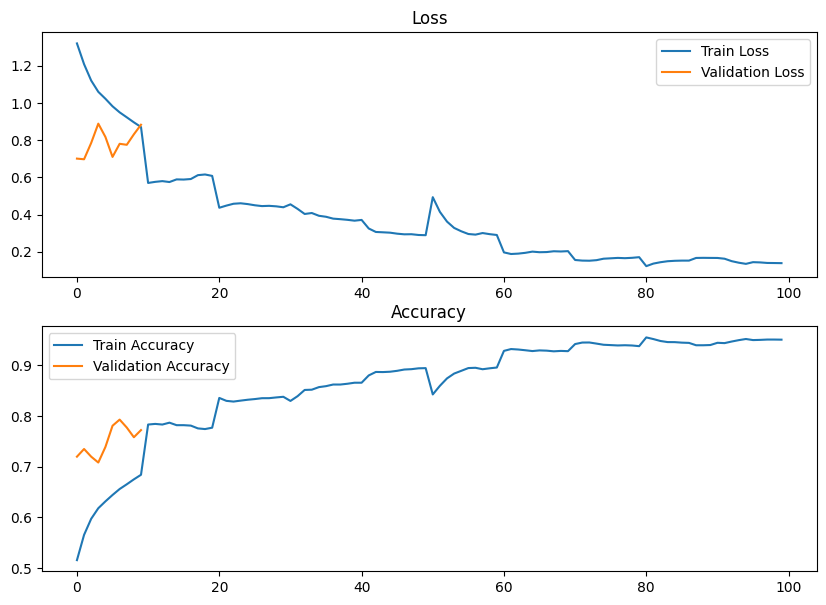

100%|██████████| 62/62 [00:02<00:00, 29.61it/s]


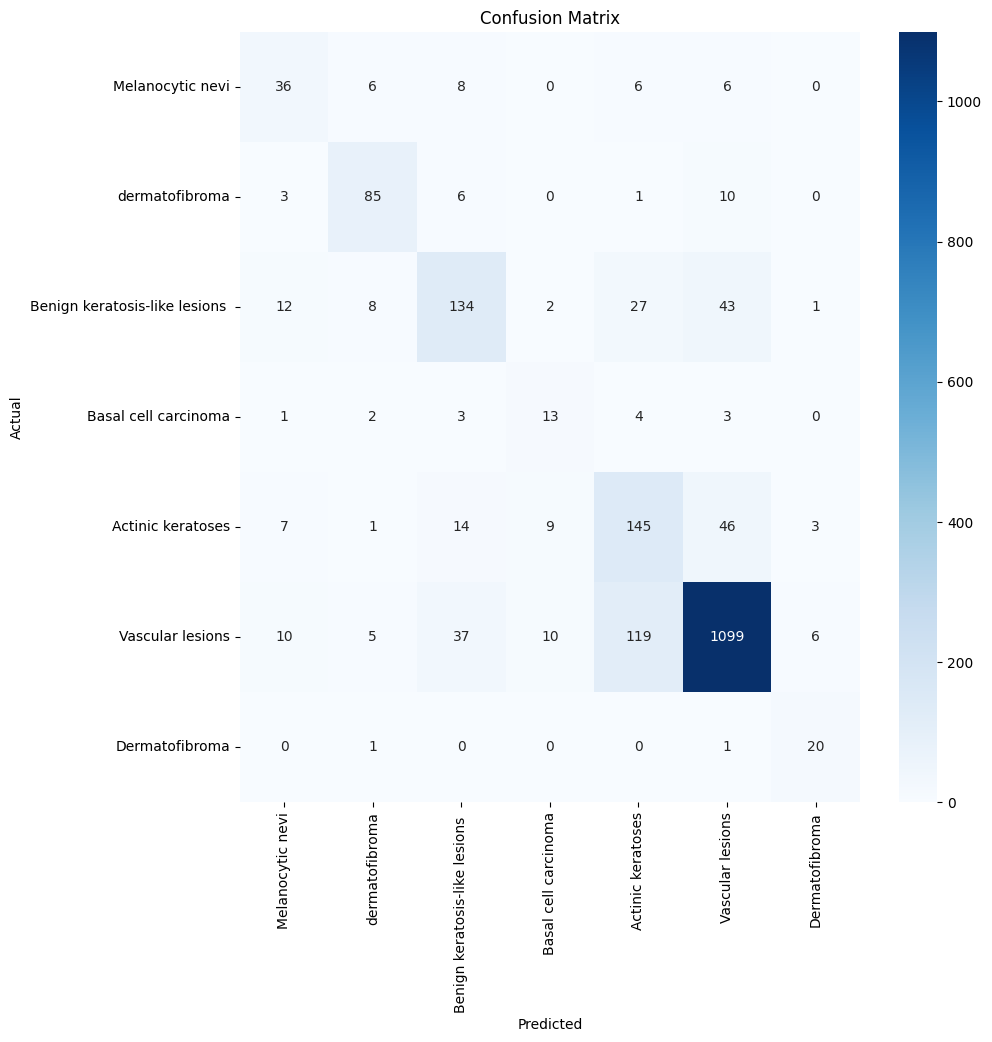

In [37]:
# Here for loading the model and evaluate it
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate the model
model.eval()

# Test the model
test_set = HAM10000(test_data,test_images, transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=n_workers)

test_acc = AverageMeter()
with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        images, labels, _ = data
        N = images.size(0)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]

        test_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

print('------------------------------------------------------------')
print('[test acc %.5f]' % (test_acc.avg))
print('------------------------------------------------------------')

# Plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.plot(total_loss_train, label='Train Loss')
plt.plot(total_loss_val, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(2, 1, 2)
plt.plot(total_acc_train, label='Train Accuracy')
plt.plot(total_acc_val, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Confusion matrix
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        images, labels, _ = data
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(prediction.cpu().numpy().flatten())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=lesion_type_dict.values(), yticklabels=lesion_type_dict.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
